In [38]:
import re
import os
import sys
import csv
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn2
from prettytable import PrettyTable
from matplotlib import pyplot as plt
from Bio import SeqIO, pairwise2, AlignIO
from collections import Counter, namedtuple
from Bio.Align import AlignInfo, MultipleSeqAlignment
import importlib
importlib.reload(sys.modules['MultipleCutter'])
from Sequence import Sequence
from MultipleCutter import MultipleCutter
from Util.SeqUtil import seqInfo, parseFasta, parseSeqByCutter
from DataStructure import refSeqSimilarityInfo
from Evaluation.DfamEvaluation import DfamEvaluation
from SharedInfo import currDatasetName, cutterA, cutterB, colorA, colorB
from Util.AnalysisUtil import listToSortedCounter, getStatisticData, mostCommonTable
from Util.PlotUtil import basicPlot, twoLabelBasicPlot, lengthScatterDistributionPlot

In [39]:
seqA = Sequence(cutterA)
parseFastaA = seqA.parseFasta()
fragmentLenListA, fragmentSeqListA = seqA.parseSeqByCutter()
repeatInfoListA = seqA.findRepeatSeqs(lengthLimit=False)
filterRepeatInfoA = seqA.filterRepeatInfo()
repeatPositionListA = seqA.getRepeatPositionList(filter=True)
seqAState = seqA.seqStateGenerator()

...start parsing dm6/chrX_sequence.fasta fasta file ...
...cost0.1535780429840088 sec to parse fasta file ...
...start parse seq by cutter: GATC
...cost 0.7920360565185547 sec to cut sequence
... start finding repeat seq ...
...cost0.06405973434448242 sec to finding repeat seq  ...


In [40]:
seqB = Sequence(cutterB)
parseFastaB = seqB.parseFasta()
fragmentLenListB, fragmentSeqListB = seqB.parseSeqByCutter()
repeatInfoListB = seqB.findRepeatSeqs(lengthLimit=False)
filterRepeatInfoB = seqB.filterRepeatInfo()
repeatPositionListB = seqB.getRepeatPositionList(filter=True)
seqBState = seqB.seqStateGenerator()

...start parsing dm6/chrX_sequence.fasta fasta file ...
...cost0.13034796714782715 sec to parse fasta file ...
...start parse seq by cutter: AAGCTT
...cost 0.9436490535736084 sec to cut sequence
... start finding repeat seq ...
...cost0.006575107574462891 sec to finding repeat seq  ...


In [41]:
seqInfo(currDatasetName, parseFastaA)

dm6/chrX_sequence dataset
 number of sequence:1
 total length:23542271



In [42]:
# repeatPositionList = repeatPositionListA + repeatPositionListB

In [43]:
# print(f'Check cutter A, B: \n {len(repeatPositionList)} = {len(repeatPositionListA)} + {len(repeatPositionListB)}')

In [44]:
# repeatPositionList[0]

In [45]:
# df = pd.DataFrame(columns=['startIdx', 'endIdx', 'length'])
# for i in repeatPositionList:
#     df = df.append({'startIdx': i.startIdx, 'endIdx': i.endIdx, 'length': i.endIdx-i.startIdx}, ignore_index=True)
# df.to_csv(f'../outputFile/PartialSeqInfo/NonFilter_Position.csv')

In [46]:
# repeat position
multipleCutter = MultipleCutter(sequence=parseFastaA[0], seqStateList = [seqAState, seqBState])
seqStateSum = multipleCutter.getSeqStateSum()
unMatchState, unionState, intersectionState = multipleCutter.getSeqStateInfo()
stateName="intersection"
matchStateIdxList = multipleCutter.getSpecificStateIdxList(stateName)
matchStateRepeatInfoList = multipleCutter.getSpecificStatePositionList()
totalRepeat = multipleCutter.cutRepeatSeqToFragment()
multipleCutter.fragmentGroupbyLen()

chr: 23542271
unMatch: 22650092, union:892179, intersection:120803
...start parse seq by cutter: AAGCTT
...cost 0.00012183189392089844 sec to cut sequence
...start parse seq by cutter: AAGCTT
...cost 0.00018095970153808594 sec to cut sequence
...start parse seq by cutter: AAGCTT
...cost 0.0001380443572998047 sec to cut sequence
...start parse seq by cutter: AAGCTT
...cost 0.00010323524475097656 sec to cut sequence
...start parse seq by cutter: GATC
...cost 0.0001251697540283203 sec to cut sequence
...start parse seq by cutter: GATC
...cost 6.604194641113281e-05 sec to cut sequence
...start parse seq by cutter: AAGCTT
...cost 5.3882598876953125e-05 sec to cut sequence
...start parse seq by cutter: GATC
...cost 3.409385681152344e-05 sec to cut sequence
...start parse seq by cutter: AAGCTT
...cost 9.012222290039062e-05 sec to cut sequence
...start parse seq by cutter: AAGCTT
...cost 6.866455078125e-05 sec to cut sequence
...start parse seq by cutter: GATC
...cost 2.7179718017578125e-05 se

In [48]:
# # [ Output GroupByData File ]

# matchDfGroupByLen = df.groupby(by=["length"], sort=True)
# tem = df.groupby(by=["length"]).agg({"length": "sum"})

# original_stdout = sys.stdout
# with open(f'../outputFile/SeqState/groupByLenData_{stateName}.txt', 'w') as f:
#     sys.stdout = f
#     for key, row in tem.iterrows():
#         print(f"{key}:")
#         for i in matchDfGroupByLen.get_group(key).index:
#             print(f"({ df.iloc[i]['startIdx']}, {df.iloc[i]['endIdx']})\n{ df.iloc[i]['seq']}")
#         print("\n")
#     sys.stdout = original_stdout

In [49]:
# [ Output SeqState File ]
# multipleCutter.generateSeqStateSumFile(filePath = '../outputFile/SeqState/seqStateSum.txt')

In [50]:
# intersection , union
# unionMatchStateIdxList = multipleCutter.getSpecificStateIdxList("union")
# len(matchStateRepeatInfoList), len(unionMatchStateIdxList)

In [51]:
# df = pd.DataFrame(columns=['startIdx', 'endIdx', 'length'])
# for i in matchStateRepeatInfoList:
#     df = df.append({'startIdx': i.startIdx, 'endIdx': i.endIdx, 'length': i.endIdx-i.startIdx}, ignore_index=True)
# df.to_csv(f'../outputFile/PartialSeqInfo/{stateName}.csv')

In [52]:
# df = pd.DataFrame(columns=['startIdx', 'endIdx', 'length'])
# for i in matchStateRepeatInfoList:
#     df = df.append({'startIdx': i.startIdx, 'endIdx': i.endIdx, 'length': i.endIdx-i.startIdx}, ignore_index=True)
# df['length'] = df['length'].astype('int32')
# df['length'].describe()
# df.to_csv(f'../outputFile/txtFile/{stateName}AndNonFilter_Position.csv')

In [53]:
# repeatPositionList = matchStateRepeatInfoList

In [54]:
# [ Mltiplecutter, Intersection or Union ]
dfam = DfamEvaluation(matchStateRepeatInfoList, hitFileName='cheX_BS2_dm6_dfam.nrph.hits')
repeatPositionLookupDic = dfam.positionBucketClassifier()
dfamPositionList = dfam.getDfamPositionList()

# from Dfam , check repeat
DRrepeatMatchList, DRmatchedFamilyAccList, DRmatchedFamilyNameList = dfam.checkDfamMatchWithRepeat()

# from repeat , check Dfam
RDrepeatMatchList, RDmatchedFamilyAccList, RDmatchedFamilyNameList = dfam.checkRepeatMatchWithDfam()

# dfam.familyMatchRatio(DRmatchedFamilyAccList)
dfam.matchRatio(DRrepeatMatchList)
# unMatchDf = dfam.getUnmatchInfo(DRrepeatMatchList)

matchCount:7	dfamCount:31	Ratio:0.22580645161290322


0.22580645161290322

In [55]:
(DRrepeatMatchList)

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [56]:
def getSequenceLengthAnalsis(inputLengthList, num=10):
    """
    1. count of common length 
    2. statistic info
    3. distribution plot
    """
    mostCommonTable(Counter(inputLengthList).most_common(num), num)
    getStatisticData(inputLengthList)
    sortedCounterList = listToSortedCounter(inputLengthList)
    basicPlot(sortedCounterList)

In [57]:
# totalDfam = DfamEvaluation(repeatPositionList, hitFileName="chrX_dm6_dfam.nrph.hits")
# totalRepeatPositionLookupDic = totalDfam.positionBucketClassifier()
# totalDfamPositionList = totalDfam.getDfamPositionList()
# unionAndFilter_Position = pd.read_csv('../outputFile/txtFile/unionAndFilter_Position.csv')
# intersectionAndFilter_Position = pd.read_csv('../outputFile/txtFile/intersectionAndFilter_Position.csv')
# Filter_Position = pd.read_csv('../outputFile/txtFile/Filter_Position.csv')
# NonFilter_Position = pd.read_csv('../outputFile/txtFile/NonFilter_Position.csv')

# unionAndFilter_Counter = listToSortedCounter((unionAndFilter_Position['length']))
# intersectionAndFilter_Counter = listToSortedCounter((intersectionAndFilter_Position['length']))

In [58]:
# df = pd.DataFrame(columns=["x", "y", "type"], dtype=float)
# for row in unionAndFilter_Counter:
#     df = df.append({"x": row[0], "y": row[1], "type": "unionAndFilter"}, ignore_index=True)
# for row in intersectionAndFilter_Counter:
#     df = df.append({"x": row[0], "y": row[1], "type": "intersectionAndFilter"}, ignore_index=True)

# df.fillna(np.nan, inplace=True)
# fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
# sns.set_style("whitegrid")
# sns.lineplot(data=df, x="x", y="y", hue="type", palette="Set1")
# ax.set_xlabel("Length", size=15)
# ax.set_ylabel("Count", size=15)
# ax.set_xlim(0, 1500)

+---------+-------+
| FragLen | Count |
+---------+-------+
|   2330  |   5   |
|    60   |   2   |
|    66   |   2   |
|   2331  |   2   |
|    59   |   1   |
|    85   |   1   |
|    49   |   1   |
|   227   |   1   |
|   334   |   1   |
|    82   |   1   |
+---------+-------+
count      31.000000
mean      705.935484
std       925.684861
min        49.000000
25%        83.500000
50%       227.000000
75%       981.500000
max      2331.000000
dtype: float64


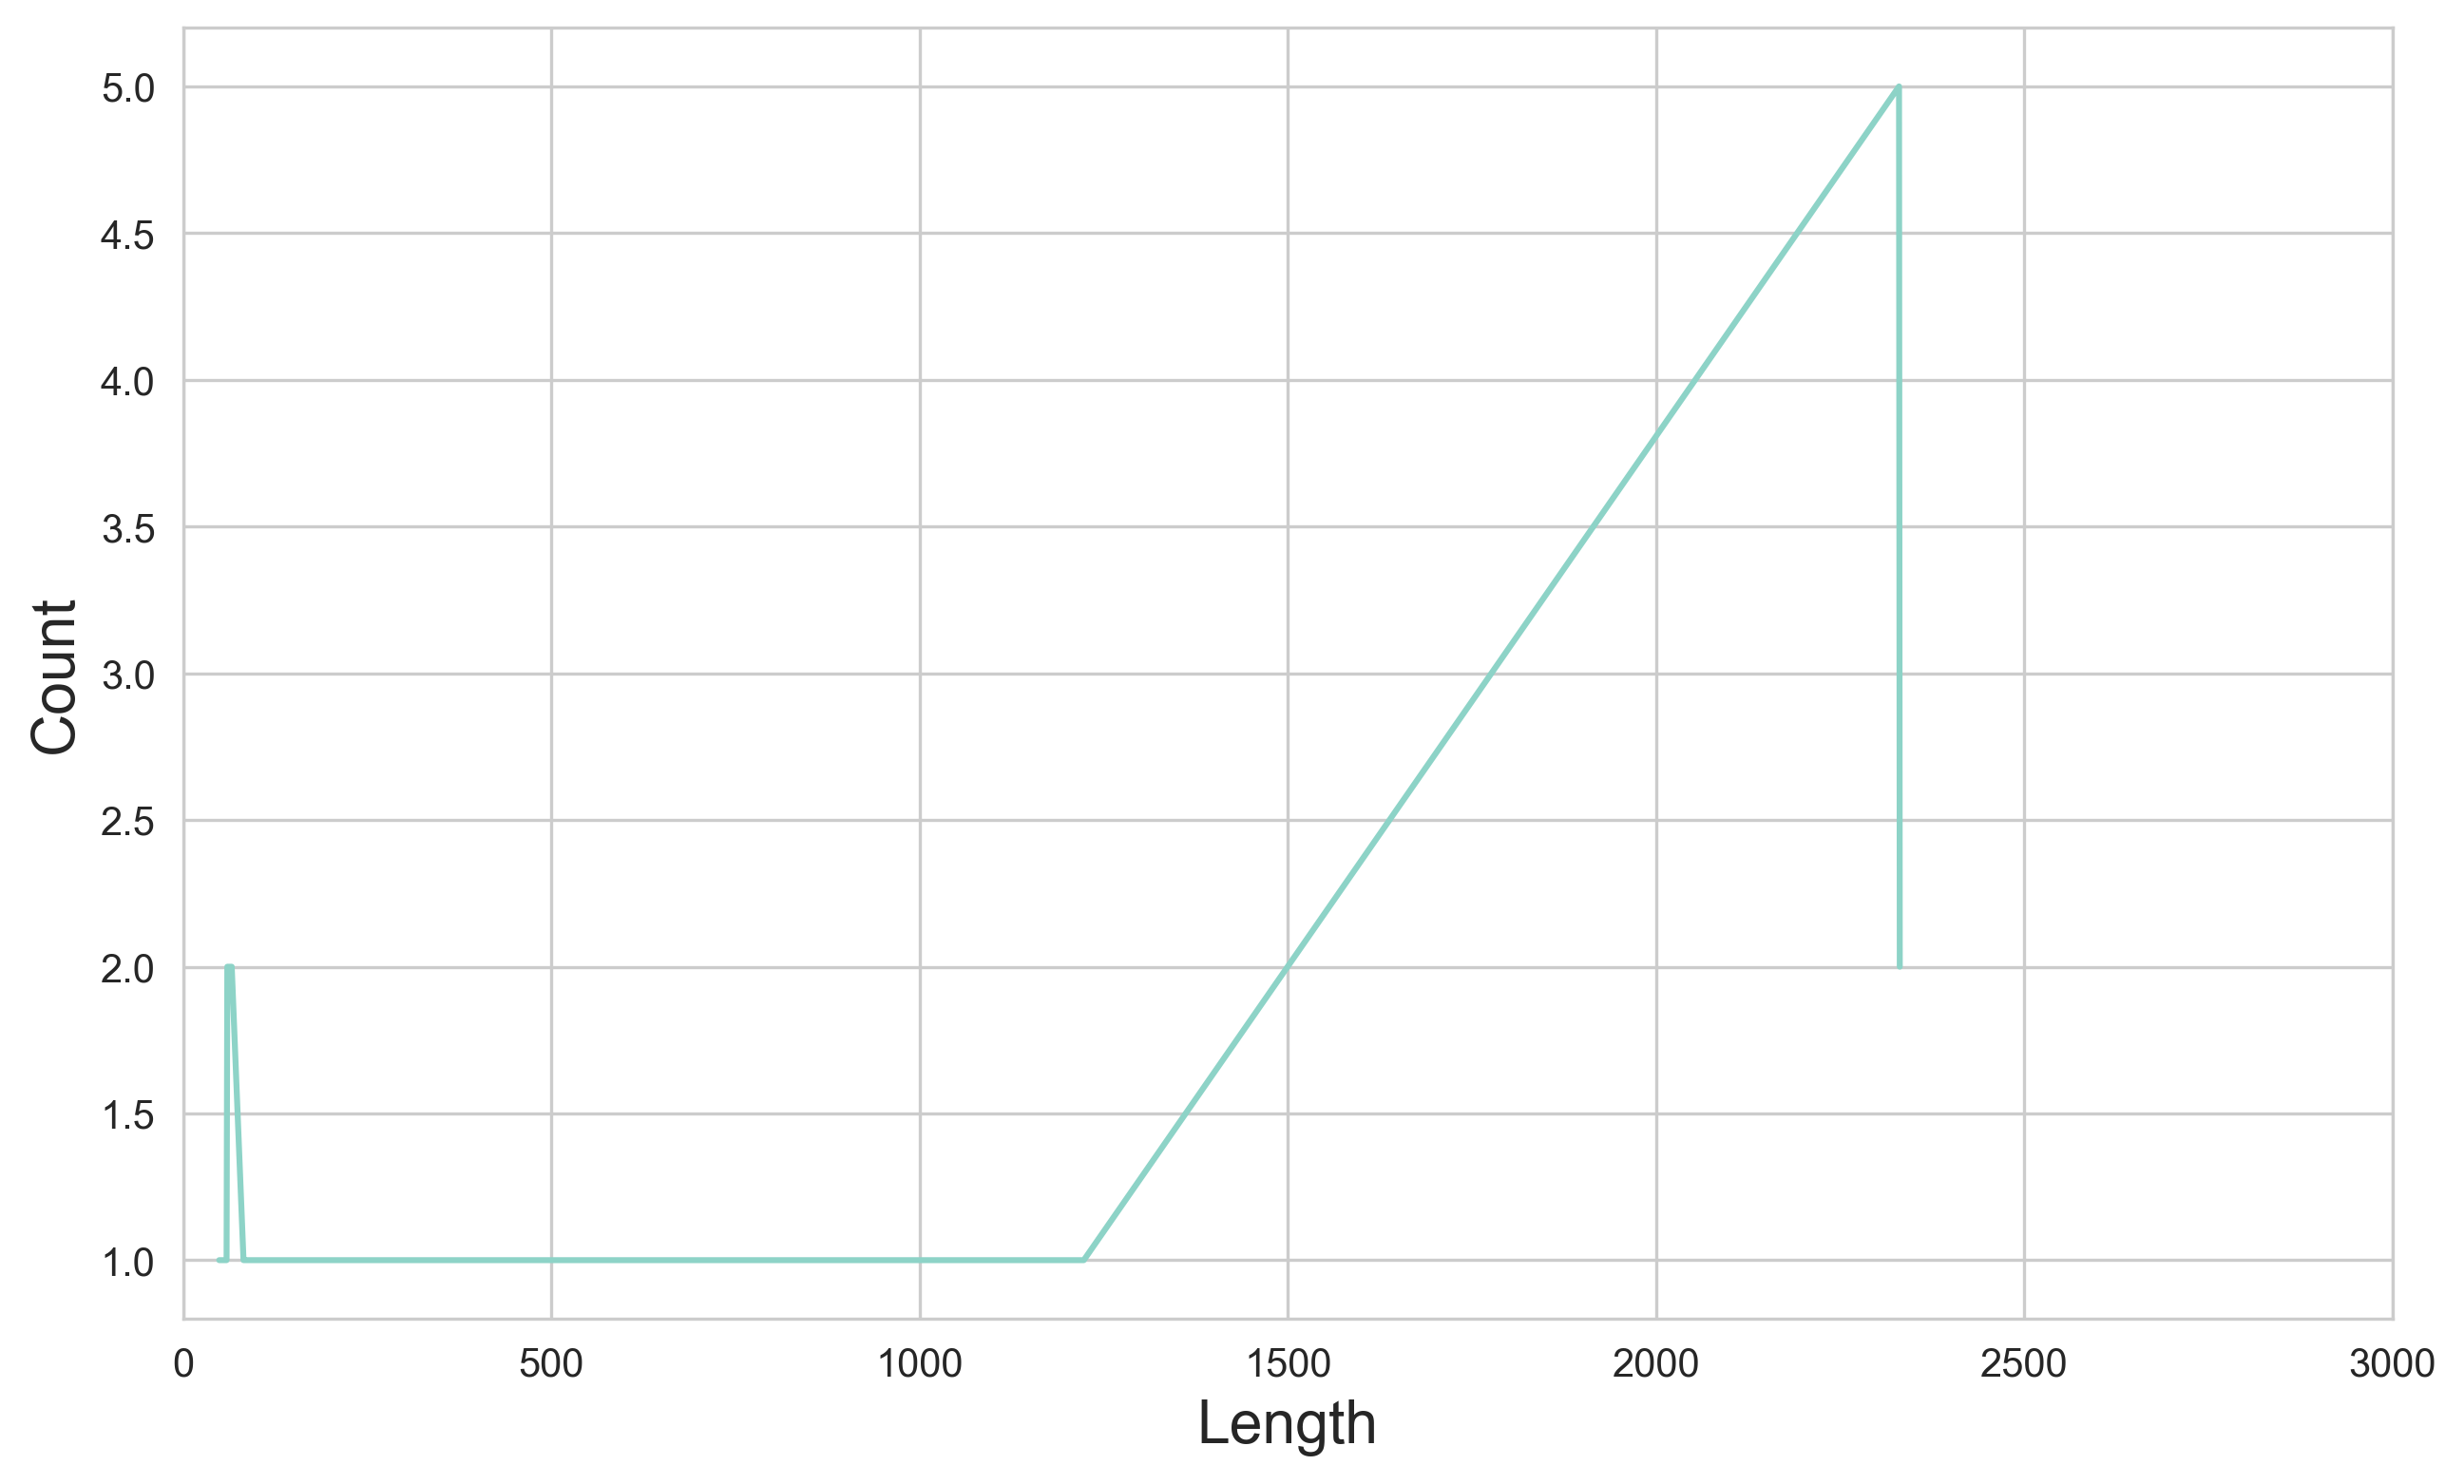

In [59]:
# Dfam ref sequence 
dfamSeqLenList = [ i.endIdx - i.startIdx for i in dfamPositionList ]
getSequenceLengthAnalsis(dfamSeqLenList)

In [60]:
BS2df = pd.DataFrame(columns=['startIdx','endIdx','length','seq'])
for i in dfamPositionList:
    BS2df = BS2df.append({'startIdx': i.startIdx,'endIdx': i.endIdx ,'length':i.endIdx-i.startIdx,'seq': parseFastaA[0][i.startIdx: i.endIdx]}, ignore_index=True)
BS2df.to_csv('./Evaluation/Source/chrX_BS2_ref.csv', index=False)

In [61]:
# Repeat sequence
# repeatFragmentLenList = [ i.endIdx - i.startIdx for i in repeatPositionList ]
# getSequenceLengthAnalsis(repeatFragmentLenList)

In [62]:
alignments = pairwise2.align.globalxx("ACG", "ACCGT")
alignments[0].score / len("ACG")

1.0

In [63]:
def consensusSeqSimilarity(consensusSeq, seqDf):
    seqSimilarityList = []
    for targetSeq in seqDf:
        alignments = pairwise2.align.globalxx(targetSeq, consensusSeq)
        targetLength = len(targetSeq)
        similarityPercentage = round(alignments[0].score / targetLength, 2)
        seqSimilarityList.append(similarityPercentage)
    return seqSimilarityList

# repeatMatchIdxList = []
# for idx, value in enumerate(RDrepeatMatchList):
#     if value == True:
#         repeatMatchIdxList.append(idx)
# repeatBasePositionList = [repeatPositionList[i] for i in repeatMatchIdxList]
# repeatSeqDf = pd.DataFrame(columns=['startIdx','endIdx', 'length', 'seq'])
# for i in repeatBasePositionList:
#     repeatSeqDf = repeatSeqDf.append({'startIdx':i.startIdx ,'endIdx': i.endIdx, 'length': (i.endIdx- i.startIdx), 'seq': str(parseFastaA[0][i.startIdx:i.endIdx])}, ignore_index=True)
conParseFasta = parseFasta(
    "DF0001549_BS2",
    "./Evaluation/Source/DF0001549_BS2.fa",
    "*",
    matchMode=False,
)
consensusSeq = conParseFasta[0].upper()
repeatDf = pd.read_csv('./Evaluation/Source/chrX_BS2_ref.csv')
seqDf = repeatDf["seq"]
seqSimilarityList = consensusSeqSimilarity(consensusSeq, seqDf)
pd.Series(seqSimilarityList).describe()

...start parsing DF0001549_BS2 fasta file ...
...cost0.0007731914520263672 sec to parse fasta file ...


count    31.000000
mean      0.970645
std       0.055253
min       0.870000
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
dtype: float64

In [64]:
a = "AAGCTTCTATTATTGGGCTGTTGCTGTTGCTTCTGTTGTTGGTGCGTCAAGCTCAGTGGTTGCTTATGGTGAACGAACCCTGTAACCACATCTGCATACGATATACCTCCTCTAGAAGAGGGGATCTCCCTACCTCCAGATAAGCCCTGTGTAGTTGGTCGCTCCTTTACCTCGGTTCTTCCGGCCACTCCACTTCTGGGTCTGGATCGCTGCATGAACGCTTGTAGTTTGCTGCAACCTTAATAATTTGCAGGATGCTGTCCACCACAGTTGTAGCAAGTGCACAGCTCGATGCGAGGCCTAGTACAGTCCTTGGCTGGGTGTTCGCCGGCACGTTTCACACAAATGTGGGCCTTACGGCAGTATTTGGCTGTGTGGCCAAACTGCTGACAACGATGGCATTGAACAATATCGTTACGCTTGCGGAGAGGCTCAATAAGTACTCTCATATGGCATAGTTACTGTCAGGATCTCCTTATTGTTTGTCGCAGCAGCTTTTGAGGTACCTGGTTCGTTTCGCCTTAGCGGTGTATGTATGTCGAGCACCTTGTGCCCGATATTTTCCAGCTCTTCCTTGATCTGGTAATGTAGCGTACAGTGGTGCAGGCCTTTCACGCATACCCTGTAAGGAATGTCTTCTTTTAGCTGGTAACAGTGGAACTCATATTCTTCGTTCTCGACTTCACTATGATGCGAAATGTGTCAGGACACCGCCCATTGACGCCCTAGCCTCAACCTCAAACTTTTCTATGTCCACTATATTTTCGATGCTCTGCATCATCGTCGTCTACTCCCTCCATTACTATAGGAGGTGGTTTGGACTGCGCCTTGTTGAGTGAGCTAGTGGTACCAGCGGAGGCTGCATCCCGCTTAGCGGCAGCAATAGCAGGTTGGTGACTGGTACTGGGCTGGTCATACAGATCGCCGATATCATTGCCTACTTGTTTGTCGACTGAGAGATGCGCAAGTAAACCAAAAAGGTTAGAGTTGCCGCCATATCTAGGTTCTGTAGACGATGGGTTTTCCCCTTGTTTGCCGATATTTGATTTAGATTTTTCCTGTCAGTCTCCGAAAAAGCACGAGACTTTCGCTTTATTTGAAAGCGCTGCGGGGCAGAACATTGGGGGCTCGAGAAAACCGCAGTAGCCAATGAGTCACCAGATTTCTAGCCAAGACTTGAACCCTAGGATAGAAAAGCTTTGAGCTCACAAATAGCTGTTTGTGCGATCGCGCGGCTGCTGGGCAGCGGAGCCCCACTTCAACTAAATTAAATGTGTCTTTTTTCCCTATTATTTCACTGGTAGTGACTTGGGGGTCACTATTTACGATATGTGCCAGTATTCTGGACTTGTCCATAAGTTTTTACCGCGAAAACTTATTTTACTTATTCCACTTTTCAGTTGCGTATTGTTAGACACGAACCTTTTTCTAGCCCGTTTTTCTATATATATAATCTTAATCGACCGACTTTCATAAAATGGGTTTTGGCCAAAAAAGGTGGTAAATTTCCCATAGTGCGTTGTATCTCCAATGTATAAATAAAACAGCCCATTTTCAAATAGTAAAATTTTTGTTCTGCTGGTTTTGTTTTTATATTTTATTTATTTATTTATTTAAAGCTAACTTAAAGTATTAAACTATAAGGTAACTCTGGATCAAAATATAGCAGATACGGGTCATACCAGGGGTGGAACCTTTAATTTGAGGGCGGTTCTAAAGGTTCTCAGCTTTGTAGGTCTCAAAAATTGATCAGACTTCACTAATGACTAATTTGCTCGTGTCGTCACTCTACTGCCAGATCAGAGCTTTATTTCACATTTCCTGTCTTAATTCTTTGGCTAGCTTAAGCTTATACATGTACAATAGGTTGCAATTAAGGGTATACGAGATATTTGTATATATGACAAAATGTAGGTTGTATTATATAAGAAATGTATGTTAAAAAATATCTTCATATTTATAATTTTTTTTAAAATTAAAATATAACTCTAAAAGATGCTATTAATTGTGCAGAGACTGTGTGTAGTCAAGAAAGGCTTTGGCTTGTACCCAAATGTTCACGATTGTAAAAAAATTAGCAATCGTCGAACTTCCGGTTTTTATTTTCCTTAACATATTCAAATGAGTACACCTAAATGCATTTATATTGCAGCACTCAAGGTAGCCTTCATTGCAATGCATTGAATGCTTTTACCAAGCATTTCATTTTGGAACAAATAAATTTTTCGTTCTGTGGGAAAAGAAGCACTGTGTAATACTTATTTTTCTCGACGAGTTCGAATAGGTCGACTTGGTGAGACAGAATAGAACCAAGTGTAATTCCACAAAGAAAATTTTAATTTTTCGTCGAAGTCAAAATTACATTTAATCTCTGTGCTTGCAGACTTTGAAGAAAAAAGAACATTTGAAGAAGAAAAATAATGAAAAATTGTTTTAATGTGTGGCCGTGACCGAAAGGAGGGGGGTGGCCACAGTGTTTGCAGTATACCGATAAAAATTGGCAAGACAAACAACAAAACGAAGAAAACCTAAACAAAATAAACCAAAAAGTTGTTGGCAAATCGATAGAAATATACAAGACTCATAAAAGCACAAATATCAAAACATTTTTCAAAAGTGTGGCCCTGGCAGTTTTGGGCGGTTTTAGGGCGTTAGAGTGGATAAAAAAACTTGCACTGGGTCTAAATCGTCTAGCTTTAATAGTTCCTGAGATCGATCGTTGTAGTGCTCTTGATGAAAACTCTTTTTATTCTTTCATTAAACGAAATTATTTAATTGACTAGCGTACTATTACCCTTCTTTTACAACTTAATCTAATCGGTATAAATTTAGGCGATTTATTATTTATAATAATAATAATAATAATCATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATTATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATTATAACAATATAACATTTAATATTATATTAATAAATAAAATAAAAATAATATAAAATATAAAATAAAATAATAAAAAAATATTTAGAAGATCATAATAAAGTAGGATTTATGTCAAGTTCCGGTCAGGCAGGTCTTGAGGGTGGTGGCGTTTCAGTGTTCTCGTTCTCGTCCTTTGGCTTTGGGCTGCGATACTTAGTCGTCTAGCTAGACTATTAGGATGAGATTCTAGGCTGTCAATTTAGGCGATTTATTATTTATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATCATAATAATAATAATAATAATAATAATAATAATAATAATCATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATTATAATAAGAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATGTTGAAAATATGTATGTAATATGTATGTATATATAATAATATGTAATAAAGTCAATGCACTGTGTCTCCCTCTTTTGGTCGCGGTAACCAAAAGCTTTTTTCTCTTTTTGTGTTATCCTCTTTAGCGTGTAATTTGGCTGCCTGCGTGCAGTAACATTGTACTCTAGATCAGTCACAATAAATACTTGAAACGAATAGGTTATGGGCCCAGCCCACGCGGACATAAAAGTGAATAGTTCTAAACGAATTTGAATATTCGGCATCTTTAAATATTGTGATTCAGGGATTTAATACGAAAAACTTATCGAAGTGAAAATGAGTTCATCAATAAACCAAATAGAAAAACTTGATGATGAAAACTACAGTGCGTGGGCTGTACAAATGAAGAGTGTCTTAATTCATGCGGAATTATGGGGGGTGGTTTGTGGACGTGTGGTTAAAAACGAAAGTGATAGTGCTGAGCTAAAGGCTTTGTTCGACGCGAAGGACGAAAAAGCATTAGAAAGTATAATGCTATGCATTAAGACATCCCAAATTAACCATATAAAAAACTGTGAGACTGCTGTAGAGGCATGGCAAAGACTTAGTGAAATCCACACTCCCTCAGGACCGGCACGACGTATATGTTTGCTTAAGCAGTTGTTGCACATGAGAATGTCTGAAACAGAAGTTGTTTCGAGTCATGTGAACAATTTTTGTGCGGTTGTTGAAAAACTAAAAGAAATTCAATTGGTGATCCAAGAAGAAGTCCTGAGTATTCTCCTGTTGTCCAGTTTGCCGGAATCGTTTGAAAGTTTCGTAGTTGCAATAGAAACGCGCGATGAGTTGCCCACATTGAAAATGTTAAAAATAAAATTACAAGAGGAAGGGCAAAGGCGTATGGCAAATGAAGAACATTCTGCAAAAAGCGAACAAAGTGCATTTGGAATTCGGTCTGCGAAACAAAAAGCGAAAAGTGACATTCAGAAGAGTGTGCAAGTAAATAATCAGCAACTGATTAACGGGAAAAGAACAGTTAATTGTTGGAACTGTGGTCGCAGCGGCCACAAAGCTGTAAACTGTAGGCAAAGGAAAGGAGAACATAGAGAGAGCGAAAACTTAAATACCGAGAAATCATTCTCTGTGCTCTGCTCAACTGTACAGCTTGGCGAATTGCCAAAAAATATGTGGTGCCTTGATTCAGGAGCAACGGCTCATTTGTGCGGTGAGAGATCGATGTTTAAAAGCTTCAGAGAGCATAAAGAGCGCATTCTTTTGGCTGGCAATAAGTATATTATAGCTGACGGTCGTGGTACAGTGAAAATAGCCTGGCGCAACTCATCATTTGAATTGATCGACGTACTCTTTGTAAAGAATTTACAATGCAACTTTATGTCGGTGTCGAAGGCAATTGAAAACGGATTTCGTGTGTCGTTCGAAAACAGGCGCGGAATTTTTTTTTTGATGCCAATGTTCCAACGTCTTGCATATTGCGCAAATGTTGATGTGAATTCCTGGATGCCTTGATATTAAGGGTGAGAGTGTCAACAGCTTCTTCTAGGTCTCTCCATCTTGGGATAAACTGTAGCTGTTGCATCTAGTGTATAATAAGCGGTAGGGGGTCGGAGCTGAACTCAGCAACGGAACGTTCAATATATCAGCATGCATATCCAGTATGCCCCTGCTGACAGCAAAATCTATATATTCTGGGGAGCCTCTACTGCCGTACGGGAATCTTGTAGGACCTCCGGTTGCTAGGGAGCTCATATCTGAGCTTAGGACCAGATTCGCTAGCTCACGCCCTCTTCGATTGCACCTACCCGCTCCCCATAGCCAGTGGGATGCATAATGCATTTAAATTCGTCCGTATTCCATATGAACCTCGGGGGCAGTATATCGCGCAAAAATTGACAGGGCCATGGCCCGTCTCGATGGCTGCAGACGCGAGTTGCACCTTGTCAGTGGCTATCGGTGTAAGAGGGAAGTGGACTAGGCTGGAATTGACCAGGATCGCTGCACCACCTTTGGCGTTACCGTCGCTCGGGTCGTTGGCAGTGTAGGACTGAAATCCAAATATTTTGGGTATATGCGTCTCCTTGTAGTGAGTCTCGCTGAGCAGCAGGACGTTGTGCGCCGCACAAAGCATTCCACTTCTGACAGCTTCGTGGACACGCCATCGGCGTTCGACACTAAGATGCGCAGTGGCATCATTATGGCGCTTGACGCGCTTGGAGAGCAGTGAGCAGATTGATGATCTGCCCCTGCTGCTGTGACTGTTGTTGCTGTTGTGTCATCATCATCATCATTAACTCCATCTGCTTCTCTTGAATCGAGCGCAAAGAATTAATACTTTCATTTAGCGTCTGCAGGATGGCTTCAATGCTGCTGCTAGCATCCATCGAGCGCTGAAGTGTGTCCCCAGACGACCTTAGCCGGCTGCGGTTTTTTTGACGTCTG"

b = "AAGCTTCTATTATTGGGCTGTTGCTGTTGCTTCTGTTGTTGGTGCGTCAAGCTCAGTGGTTGCTTATGGTGAACGAACCCTGTAACCACATCTGCATACGATATACCTCCTCTAGAAGAGGGGATCTCCCTACCTCCAGATAAGCCCTGTGTAGTTGGTCGCTCCTTTACCTCGGTTCTTCCGGCCACTCCACTTCTGGGTCTGGATCGCTGCATGAACGCTTGTAGTTTGCTGCAACCTTAATAATTTGCAGGATGCTGTCCACCACAGTTGTAGCAAGTGCACAGCTCGATGCGAGGCCTAGTACAGTCCTTGGCTGGGTGTTCGCCGGCACGTTTCACACAAATGTGGGCCTTACGGCAGTATTTGGCTGTGTGGCCAAACTGCTGACAACGATGGCATTGAACAATATCGTTACGCTTGCGGAGAGGCTCAATAAGTACTCTCATATGGCATAGTTACTGTCAGGATCTCCTTATTGTTTGTCGCAGCAGCTTTTGAGGTACCTGGTTCGTTTCGCCTTAGCGGTGTATGTATGTCGAGCACCTTGTGCCCGATATTTTCCAGCTCTTCCTTGATCTGGTAATGTAGCGTACAGTGGTGCAGGCCTTTCACGCATACCCTGTAAGGAATGTCTTCTTTTAGCTGGTAACAGTGGAACTCATATTCTTCGTTCTCGACTTCACTATGATGCGAAATGTGTCAGGACACCGCCCATTGACGCCCTAGCCTCAACCTCAAACTTTTCTATGTCCACTATATTTTCGATGCTCTGCATCATCGTCGTCTACTCCCTCCATTACTATAGGAGGTGGTTTGGACTGCGCCTTGTTGAGTGAGCTAGTGGTACCAGCGGAGGCTGCATCCCGCTTAGCGGCAGCAATAGCAGGTTGGTGACTGGTACTGGGCTGGTCATACAGATCGCCGATATCATTGCCTACTTGTTTGTCGACTGAGAGATGCGCAAGTAAACCAAAAAGGTTAGAGTTGCCGCCATATCTAGGTTCTGTAGACGATGGGTTTTCCCCTTGTTTGCCGATATTTGATTTAGATTTTTCCTGTCAGTCTCCGAAAAAGCACGAGACTTTCGCTTTATTTGAAAGCGCTGCGGGGCAGAACATTGGGGGCTCGAGAAAACCGCAGTAGCCAATGAGTCACCAGATTTCTAGCCAAGACTTGAACCCTAGGATAGAAAAGCTTTGAGCTCACAAATAGCTGTTTGTGCGATCGCGCGGCTGCTGGGCAGCGGAGCCCCACTTCAACTAAATTAAATGTGTCTTTTTTCCCTATTATTTCACTGGTAGTGACTTGGGGGTCACTATTTACGATATGTGCCAGTATTCTGGACTTGTCCATAAGTTTTTACCGCGAAAACTTATTTTACTTATTCCACTTTTCAGTTGCGTATTGTTAGACACGAACCTTTTTCTAGCCCGTTTTTCTATATATATAATCTTAATCGACCGACTTTCATAAAATGGGTTTTGGCCAAAAAAGGTGGTAAATTTCCCATAGTGCGTTGTATCTCCAATGTATAAATAAAACAGCCCATTTTCAAATAGTAAAATTTTTGTTCTGCTGGTTTTGTTTTTATATTTTATTTATTTATTTATTTAAAGCTAACTTAAAGTATTAAACTATAAGGTAACTCTGGATCAAAATATAGCAGATACGGGTCATACCAGGGGTGGAACCTTTAATTTGAGGGCGGTTCTAAAGGTTCTCAGCTTTGTAGGTCTCAAAAATTGATCAGACTTCACTAATGACTAATTTGCTCGTGTCGTCACTCTACTGCCAGATCAGAGCTTTATTTCACATTTCCTGTCTTAATTCTTTGGCTAGCTTAAGCTTATACATGTACAATAGGTTGCAATTAAGGGTATACGAGATATTTGTATATATGACAAAATGTAGGTTGTATTATATAAGAAATGTATGTTAAAAAATATCTTCATATTTATAATTTTTTTTAAAATTAAAATATAACTCTAAAAGATGCTATTAATTGTGCAGAGACTGTGTGTAGTCAAGAAAGGCTTTGGCTTGTACCCAAATGTTCACGATTGTAAAAAAATTAGCAATCGTCGAACTTCCGGTTTTTATTTTCCTTAACATATTCAAATGAGTACACCTAAATGCATTTATATTGCAGCACTCAAGGTAGCCTTCATTGCAATGCATTGAATGCTTTTACCAAGCATTTCATTTTGGAACAAATAAATTTTTCGTTCTGTGGGAAAAGAAGCACTGTGTAATACTTATTTTTCTCGACGAGTTCGAATAGGTCGACTTGGTGAGACAGAATAGAACCAAGTGTAATTCCACAAAGAAAATTTTAATTTTTCGTCGAAGTCAAAATTACATTTAATCTCTGTGCTTGCAGACTTTGAAGAAAAAAGAACATTTGAAGAAGAAAAATAATGAAAAATTGTTTTAATGTGTGGCCGTGACCGAAAGGAGGGGGGTGGCCACAGTGTTTGCAGTATACCGATAAAAATTGGCAAGACAAACAACAAAACGAAGAAAACCTAAACAAAATAAACCAAAAAGTTGTTGGCAAATCGATAGAAATATACAAGACTCATAAAAGCACAAATATCAAAACATTTTTCAAAAGTGTGGCCCTGGCAGTTTTGGGCGGTTTTAGGGCGTTAGAGTGGATAAAAAAACTTGCACTGGGTCTAAATCGTCTAGCTTTAATAGTTCCTGAGATCGATCGTTGTAGTGCTCTTGATGAAAACTCTTTTTATTCTTTCATTAAACGAAATTATTTAATTGACTAGCGTACTATTACCCTTCTTTTACAACTTAATCTAATCGGTATAAATTTAGGCGATTTATTATTTATAATAATAATAATAATAATCATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATTATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATTATAACAATATAACATTTAATATTATATTAATAAATAAAATAAAAATAATATAAAATATAAAATAAAATAATAAAAAAATATTTAGAAGATCATAATAAAGTAGGATTTATGTCAAGTTCCGGTCAGGCAGGTCTTGAGGGTGGTGGCGTTTCAGTGTTCTCGTTCTCGTCCTTTGGCTTTGGGCTGCGATACTTAGTCGTCTAGCTAGACTATTAGGATGAGATTCTAGGCTGTCAATTTAGGCGATTTATTATTTATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATCATAATAATAATAATAATAATAATAATAATAATAATAATCATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATTATAATAAGAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATGTTGAAAATATGTATGTAATATGTATGTATATATAATAATATGTAATAAAGTCAATGCACTGTGTCTCCCTCTTTTGGTCGCGGTAACCAAAAGCTTTTTTCTCTTTTTGTGTTATCCTCTTTAGCGTGTAATTTGGCTGCCTGCGTGCAGTAACATTGTACTCTAGATCAGTCACAATAAATACTTGAAACGAATAGGTTATGGGCCCAGCCCACGCGGACATAAAAGTGAATAGTTCTAAACGAATTTGAATATTCGGCATCTTTAAATATTGTGATTCAGGGATTTAATACGAAAAACTTATCGAAGTGAAAATGAGTTCATCAATAAACCAAATAGAAAAACTTGATGATGAAAACTACAGTGCGTGGGCTGTACAAATGAAGAGTGTCTTAATTCATGCGGAATTATGGGGGGTGGTTTGTGGACGTGTGGTTAAAAACGAAAGTGATAGTGCTGAGCTAAAGGCTTTGTTCGACGCGAAGGACGAAAAAGCATTAGAAAGTATAATGCTATGCATTAAGACATCCCAAATTAACCATATAAAAAACTGTGAGACTGCTGTAGAGGCATGGCAAAGACTTAGTGAAATCCACACTCCCTCAGGACCGGCACGACGTATATGTTTGCTTAAGCAGTTGTTGCACATGAGAATGTCTGAAACAGAAGTTGTTTCGAGTCATGTGAACAATTTTTGTGCGGTTGTTGAAAAACTAAAAGAAATTCAATTGGTGATCCAAGAAGAAGTCCTGAGTATTCTCCTGTTGTCCAGTTTGCCGGAATCGTTTGAAAGTTTCGTAGTTGCAATAGAAACGCGCGATGAGTTGCCCACATTGAAAATGTTAAAAATAAAATTACAAGAGGAAGGGCAAAGGCGTATGGCAAATGAAGAACATTCTGCAAAAAGCGAACAAAGTGCATTTGGAATTCGGTCTGCGAAACAAAAAGCGAAAAGTGACATTCAGAAGAGTGTGCAAGTAAATAATCAGCAACTGATTAACGGGAAAAGAACAGTTAATTGTTGGAACTGTGGTCGCAGCGGCCACAAAGCTGTAAACTGTAGGCAAAGGAAAGGAGAACATAGAGAGAGCGAAAACTTAAATACCGAGAAATCATTCTCTGTGCTCTGCTCAACTGTACAGCTTGGCGAATTGCCAAAAAATATGTGGTGCCTTGATTCAGGAGCAACGGCTCATTTGTGCGGTGAGAGATCGATGTTTAAAAGCTTCAGAGAGCATAAAGAGCGCATTCTTTTGGCTGGCAATAAGTATATTATAGCTGACGGTCGTGGTACAGTGAAAATAGCCTGGCGCAACTCATCATTTGAATTGATCGACGTACTCTTTGTAAAGAATTTACAATGCAACTTTATGTCGGTGTCGAAGGCAATTGAAAACGGATTTCGTGTGTCGTTCGAAAACAGGCGCGGAATTTTTTTTTTGATGCCAATGTTCCAACGTCTTGCATATTGCGCAAATGTTGATGTGAATTCCTGGATGCCTTGATATTAAGGGTGAGAGTGTCAACAGCTTCTTCTAGGTCTCTCCATCTTGGGATAAACTGTAGCTGTTGCATCTAGTGTATAATAAGCGGTAGGGGGTCGGAGCTGAACTCAGCAACGGAACGTTCAATATATCAGCATGCATATCCAGTATGCCCCTGCTGACAGCAAAATCTATATATTCTGGGGAGCCTCTACTGCCGTACGGGAATCTTGTAGGACCTCCGGTTGCTAGGGAGCTCATATCTGAGCTTAGGACCAGATTCGCTAGCTCACGCCCTCTTCGATTGCACCTACCCGCTCCCCATAGCCAGTGGGATGCATAATGCATTTAAATTCGTCCGTATTCCATATGAACCTCGGGGGCAGTATATCGCGCAAAAATTGACAGGGCCATGGCCCGTCTCGATGGCTGCAGACGCGAGTTGCACCTTGTCAGTGGCTATCGGTGTAAGAGGGAAGTGGACTAGGCTGGAATTGACCAGGATCGCTGCACCACCTTTGGCGTTACCGTCGCTCGGGTCGTTGGCAGTGTAGGACTGAAATCCAAATATTTTGGGTATATGCGTCTCCTTGTAGTGAGTCTCGCTGAGCAGCAGGACGTTGTGCGCCGCACAAAGCATTCCACTTCTGACAGCTTCGTGGACACGCCATCGGCGTTCGACACTAAGATGCGCAGTGGCATCATTATGGCGCTTGACGCGCTTGGAGAGCAGTGAGCAGATTGATGATCTGCCCCTGCTGCTGTGACTGTTGTTGCTGTTGTGTCATCATCATCATCATTAACTCCATCTGCTTCTCTTGAATCGAGCGCAAAGAATTAATACTTTCATTTAGCGTCTGCAGGATGGCTTCAATGCTGCTGCTAGCATCCATCGAGCGCTGAAGTGTGTCCCCAGACGACCTTAGCCGGCTGCGGTTTTTTTGACGTCTG"

a == b

True

(0.0, 1.1)

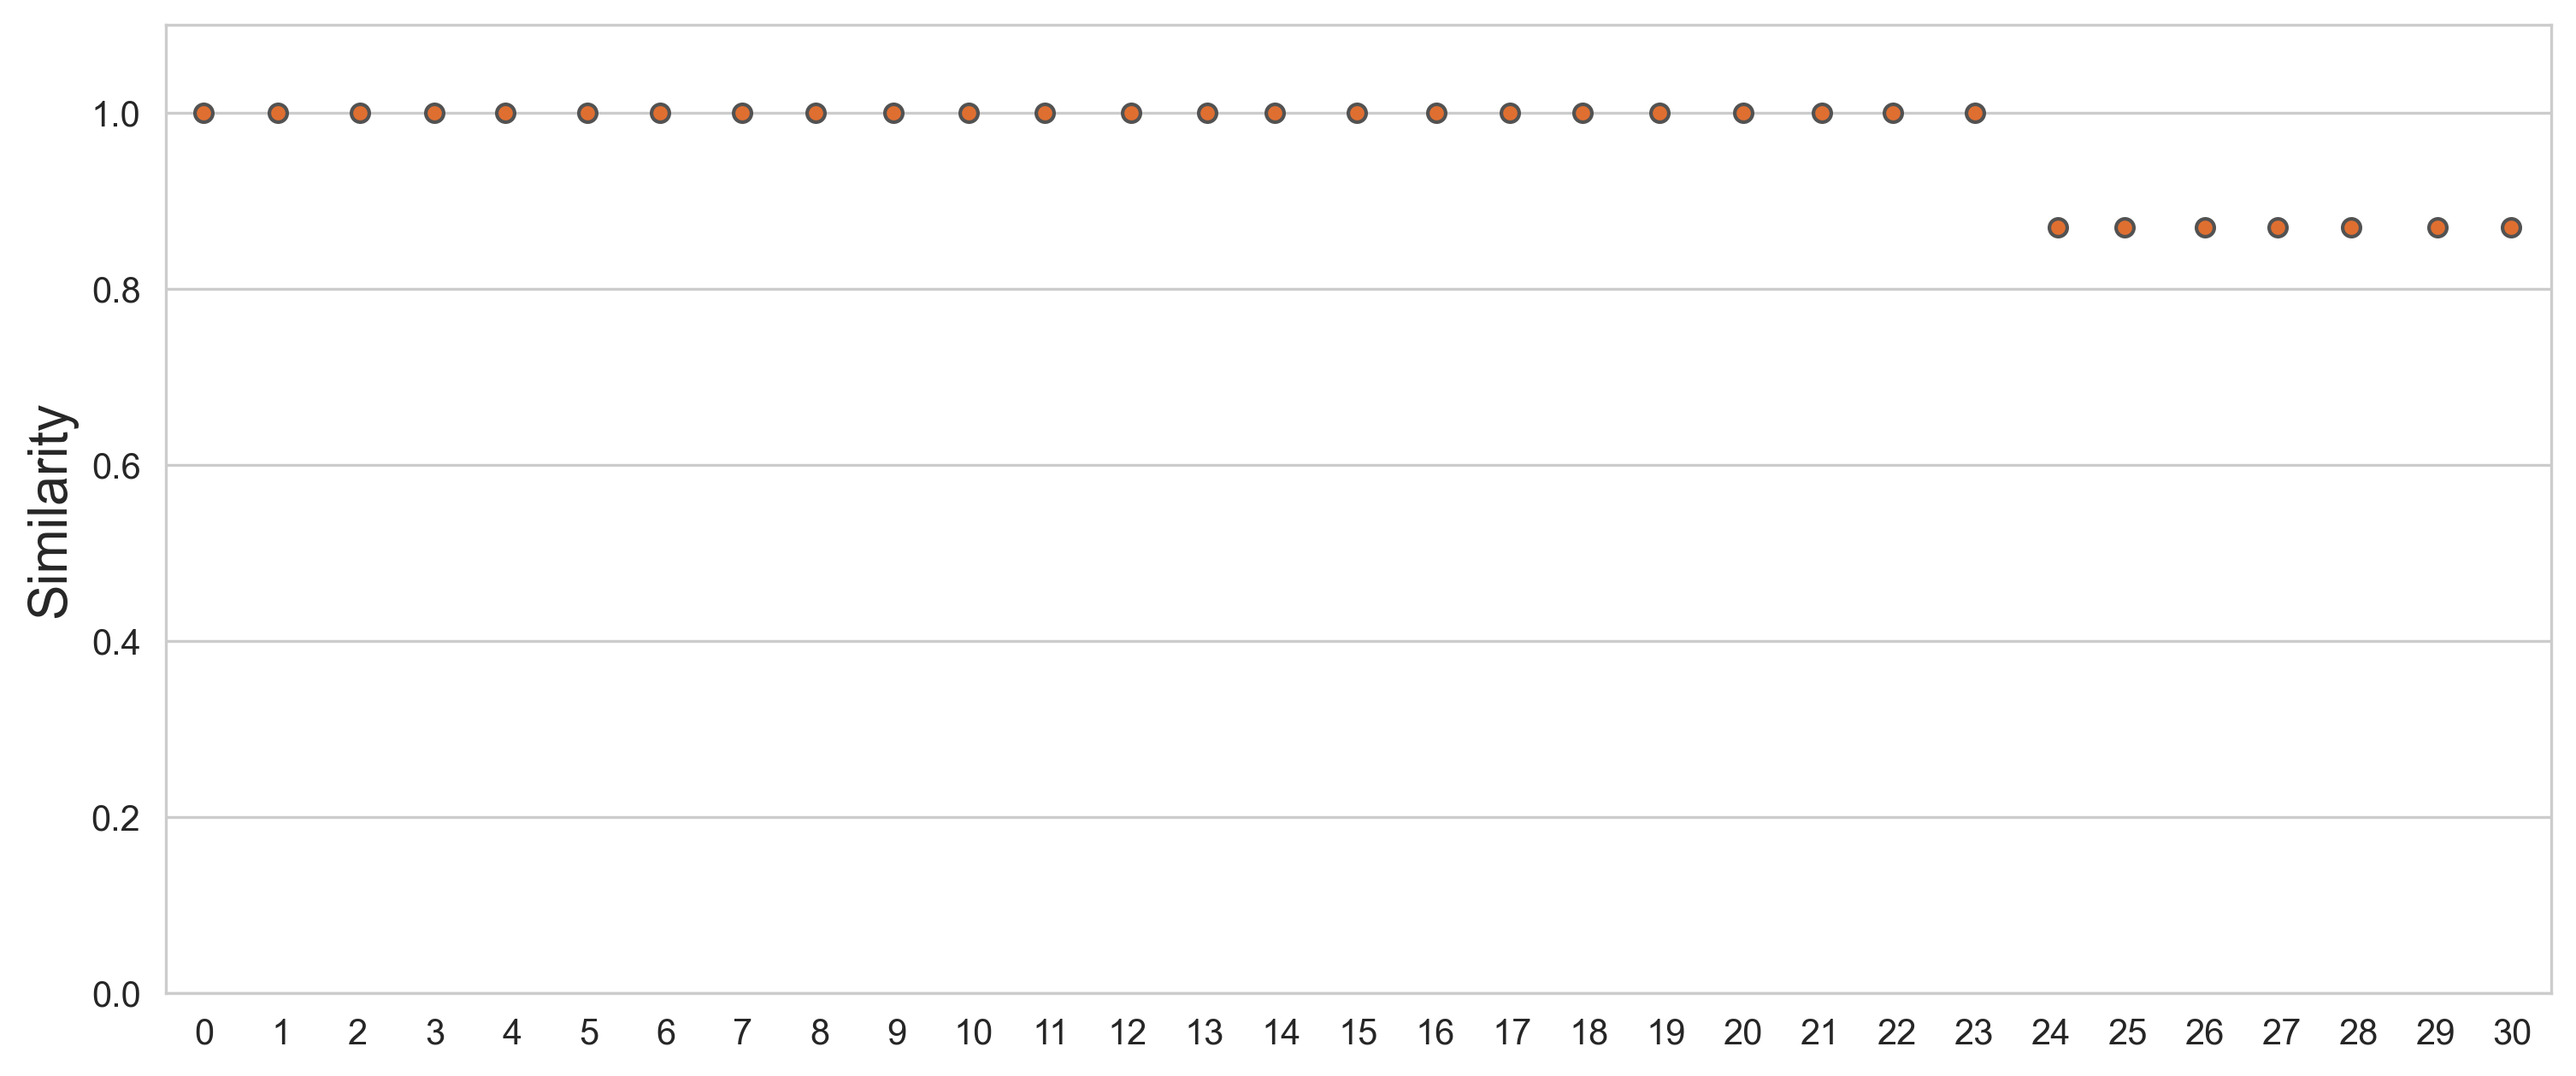

In [65]:
xData = [*range(len(seqSimilarityList))]
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)
sns.set_style("whitegrid")
sns.stripplot(x=xData, y=seqSimilarityList, linewidth=1.0, color=colorA)
ax.set_ylabel("Similarity", size=15)
ax.set_ylim(0,1.1)

In [66]:
# # Test cutter A
# repeatPositionListA = seqA.getRepeatPositionList()
# dfamA = DfamEvaluation(repeatPositionListA)
# repeatPositionLookupDicA = dfamA.positionBucketClassifier()
# dfamPositionListA = dfamA.getDfamPositionList()
# dfamPositionLookupDicA = dfamA.positionBucketClassifier()
# DRrepeatMatchListA, DRmatchedFamilyAccListA, DRmatchedFamilyNameListA = dfamA.checkDfamMatchWithRepeat()

In [67]:
# totalLen = len(DRrepeatMatchListA)
# matchLenA = len(list(filter(lambda x: x, DRrepeatMatchListA)))
# ratio = matchLenA / totalLen
# print(f"matchCount:{matchLenA}\tdfamCount:{totalLen}\tRatio:{ratio}")

In [68]:
# # Test cutter B
# repeatPositionListB = seqB.getRepeatPositionList()
# dfamB = DfamEvaluation(repeatPositionListB)
# repeatPositionLookupDicB = dfamB.positionBucketClassifier()
# dfamPositionListB = dfamB.getDfamPositionList()
# dfamPositionLookupDicB = dfamB.positionBucketClassifier()
# DRrepeatMatchListB, DRmatchedFamilyAccListB, DRmatchedFamilyNameListB = dfamB.checkDfamMatchWithRepeat()

In [69]:
# totalLen = len(DRrepeatMatchListB)
# matchLenB = len(list(filter(lambda x: x, DRrepeatMatchListB)))
# ratio = matchLenB / totalLen
# print(f"matchCount:{matchLenB}\tdfamCount:{totalLen}\tRatio:{ratio}")

In [70]:
# total = 597
# middle = matchLenA+matchLenB - total
# plt.figure(linewidth=10, facecolor="white", dpi=1200)
# # plt.figure(linewidth=10, facecolor="white")
# v = venn2(subsets = (matchLenA-middle, matchLenB-middle, middle), set_labels = (f'CutterA - {cutterA} ', f'CutterB - {cutterB}'), set_colors=(colorA, colorB))
# plt.show()
